In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve)
from sklearn.calibration import CalibratedClassifierCV

from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv('../Dataset/PS_20174392719_1491204439457_log.csv')

In [8]:
cols = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest', 'isFraud']
data = data[cols]

In [9]:
# ----------------------------
# Label Encoding for "type"
# ----------------------------
data['type'].replace({'CASH_OUT': 0, 'PAYMENT': 1, 'CASH_IN': 2, 'TRANSFER': 3, 'DEBIT': 4}, inplace=True)
print("\nAfter label encoding, 'type' value counts:\n", data['type'].value_counts())
print("\nFirst 5 rows after label encoding:\n", data.head())


After label encoding, 'type' value counts:
 type
0    2237500
1    2151495
2    1399284
3     532909
4      41432
Name: count, dtype: int64

First 5 rows after label encoding:
    type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     3    181.00          181.0            0.00             0.0   
3     0    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  
0             0.0        0  
1             0.0        0  
2             0.0        1  
3             0.0        1  
4             0.0        0  


In [10]:
# ----------------------------
# Splitting the Data and Target
# ----------------------------
X = data.drop(['isFraud'], axis=1)
print("\nX shape is:", X.shape)
y = data['isFraud']
print("y shape is:", y.shape)


X shape is: (6362620, 6)
y shape is: (6362620,)


In [11]:
# ----------------------------
# Data Partitioning / Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    shuffle=True)
print("\nX_train shape is:", X_train.shape)
print("X_test shape is:", X_test.shape)
print("y_train shape is:", y_train.shape)
print("y_test shape is:", y_test.shape)


X_train shape is: (4453834, 6)
X_test shape is: (1908786, 6)
y_train shape is: (4453834,)
y_test shape is: (1908786,)


In [12]:
# ----------------------------
# Scaling the Features
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Before sampling, class distribution in y_train:
isFraud
0    4448056
1       5778
Name: count, dtype: int64

After SMOTETomek, class distribution in y_train_resampled:
isFraud
0    4447364
1    4447364
Name: count, dtype: int64


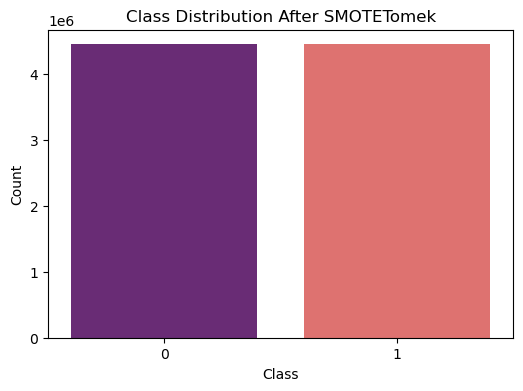

In [13]:
# ----------------------------
# Apply Alternative Sampling (SMOTETomek) to the Training Data
# ----------------------------
print("\nBefore sampling, class distribution in y_train:")
print(pd.Series(y_train).value_counts())

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

resampled_counts = pd.Series(y_train_resampled).value_counts()
print("\nAfter SMOTETomek, class distribution in y_train_resampled:")
print(resampled_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=resampled_counts.index, y=resampled_counts.values, palette='magma')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTETomek')
plt.show()

In [14]:
# ----------------------------
# Hyperparameter Tuning with GridSearchCV for XGBoost
# ----------------------------
# Use the best parameters already found to save time.
# Here, we set them directly.
best_params = {'colsample_bytree': 1.0, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1.0}
print("\nUsing best parameters:", best_params)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, 
                          eval_metric='logloss', random_state=42, **best_params)



Using best parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1.0}


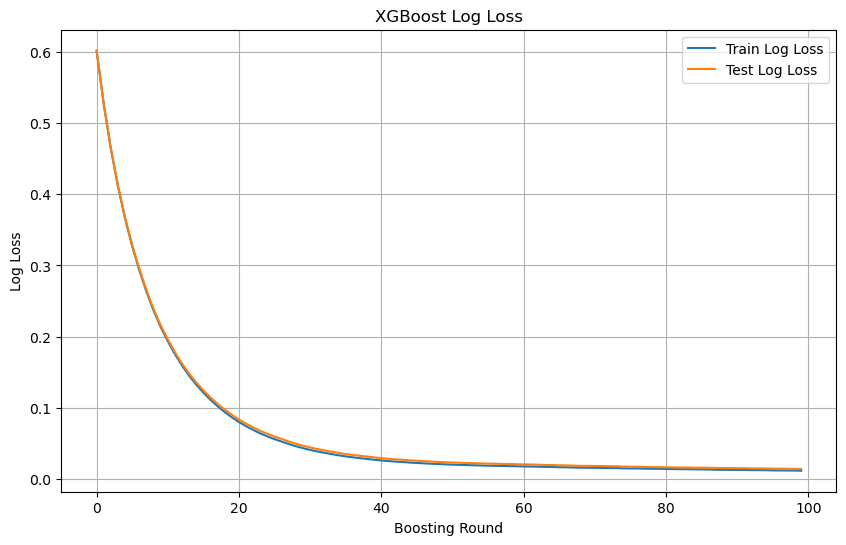

In [15]:

# ----------------------------
# Train XGBoost Model with Evaluation Logging
# ----------------------------
eval_set = [(X_train_resampled, y_train_resampled), (X_test_scaled, y_test)]
xgb_model.fit(X_train_resampled, y_train_resampled, eval_set=eval_set, verbose=False)
results = xgb_model.evals_result()

# Plot log loss over boosting rounds
epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)
plt.figure(figsize=(10,6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test Log Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.legend()
plt.grid(True)
plt.show()


Classification Report with custom threshold (0.7):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.64      0.93      0.76      2435

    accuracy                           1.00   1908786
   macro avg       0.82      0.97      0.88   1908786
weighted avg       1.00      1.00      1.00   1908786



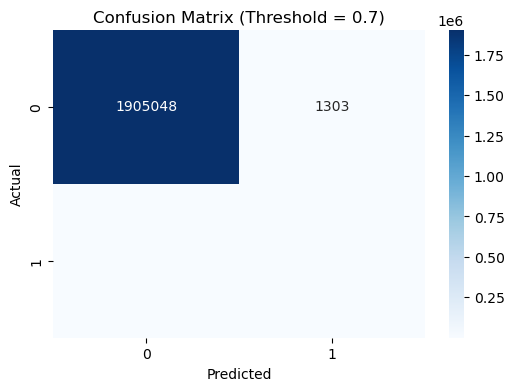

In [25]:
# ----------------------------
# Evaluate the Model on the Test Set with Threshold Adjustment
# ----------------------------
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# First, show the current performance with a fixed threshold (0.7) as before:
custom_threshold = 0.97
y_pred_custom = (y_proba >= custom_threshold).astype(int)
print("\nClassification Report with custom threshold (0.7):")
print(classification_report(y_test, y_pred_custom))

# Plot Confusion Matrix for threshold = 0.7
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix (Threshold = 0.7)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



Threshold Tuning Table (showing first 10 rows):
   Threshold  Precision  Recall  F1 Score
0   0.000004   0.001276     1.0  0.002548
1   0.000004   0.001276     1.0  0.002548
2   0.000004   0.001276     1.0  0.002548
3   0.000005   0.001276     1.0  0.002548
4   0.000005   0.001276     1.0  0.002548
5   0.000005   0.001276     1.0  0.002548
6   0.000005   0.001276     1.0  0.002548
7   0.000005   0.001276     1.0  0.002548
8   0.000005   0.001276     1.0  0.002548
9   0.000005   0.001276     1.0  0.002548


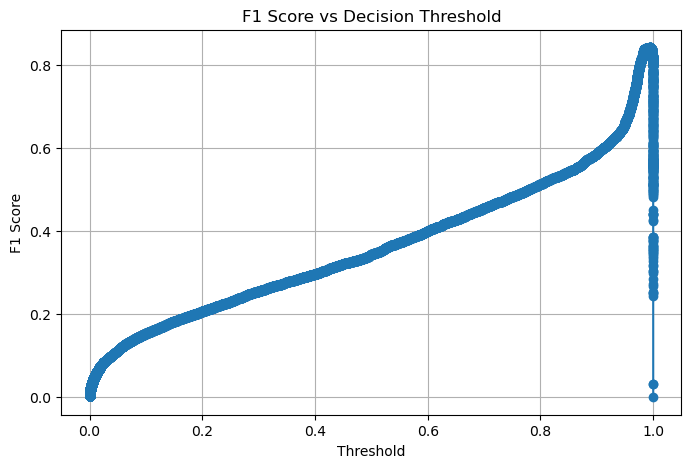


Best threshold based on maximum F1: 0.9947018027305603

Classification Report with best threshold (0.995):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.95      0.76      0.84      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.88      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786


Classification Report Table with Best Threshold:
              precision    recall  f1-score       support
0              0.999690  0.999951  0.999821  1.906351e+06
1              0.951988  0.757290  0.843550  2.435000e+03
accuracy       0.999642  0.999642  0.999642  9.996417e-01
macro avg      0.975839  0.878620  0.921685  1.908786e+06
weighted avg   0.999629  0.999642  0.999621  1.908786e+06


In [ ]:
# ----------------------------
# Threshold Tuning Based on Precision-Recall
# ----------------------------
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba)
# Compute F1 for each threshold (f1_scores will have length m+1)
f1_scores = 2 * precision_vals * recall_vals / (precision_vals + recall_vals + 1e-8)
# thresholds returned by precision_recall_curve has length m, so append one to match length m+1
thresholds = np.append(thresholds, 1.0)

# Now, all arrays (thresholds, precision_vals, recall_vals, f1_scores) have length m+1
tuning_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_vals,
    'Recall': recall_vals,
    'F1 Score': f1_scores
})

# Plot F1 vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Decision Threshold')
plt.grid(True)
plt.show()

# Evaluate using the best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("\nBest threshold based on maximum F1:", best_threshold)

y_pred_best = (y_proba >= best_threshold).astype(int)
print("\nClassification Report with best threshold ({}):".format(round(best_threshold, 3)))
report_best = classification_report(y_test, y_pred_best, output_dict=True)
print(classification_report(y_test, y_pred_best))
report_best_df = pd.DataFrame(report_best).transpose()
print("\nClassification Report Table with Best Threshold:")
print(report_best_df)


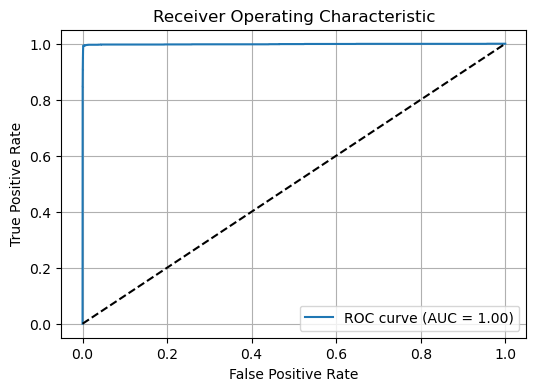

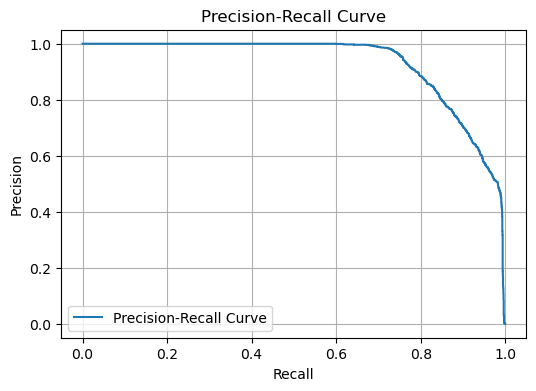

In [20]:

# ----------------------------
# ROC and Precision-Recall Curves
# ----------------------------
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


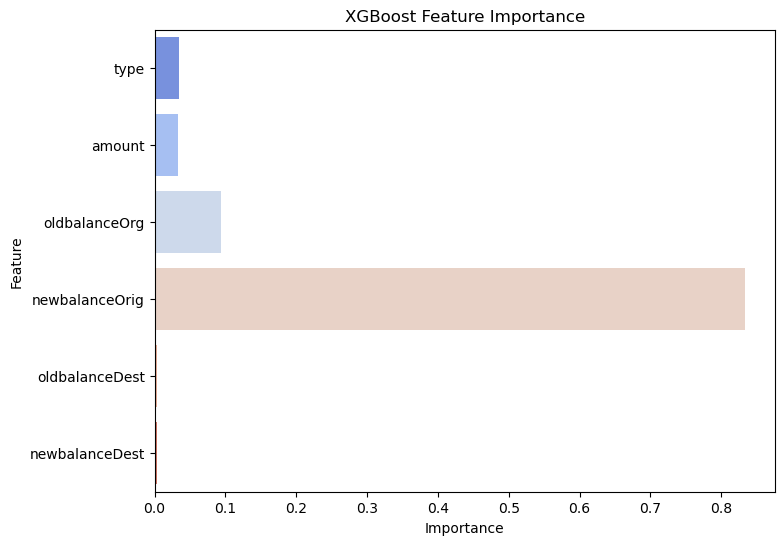

In [21]:
# ----------------------------
# Feature Importance from XGBoost
# ----------------------------
importances = xgb_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, palette='coolwarm')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()